<a href="https://colab.research.google.com/github/haan-doobey/Two_Phase_Rel_Perm_Curve_Fitting/blob/main/Imbibition_relperm_curve_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


--- Running Analysis for Water Wet Case ---

--- True Parameters for water_wet Case ---
S_wc (Swi): 0.150
S_or: 0.350
krw_max: 0.180
kro_max: 1.000
Nw: 4.000
No: 2.000
kt: 0.000

--- Fitted Parameters ---
S_wc (Swi): 0.147
S_or: 0.356
krw_max: 0.180
kro_max: 1.000 (Fixed at 1.0 in fit for this example)
Nw: 4.242
No: 1.951
kt: 0.000
True crossover Sw: 0.525
Fitted crossover Sw: 0.528


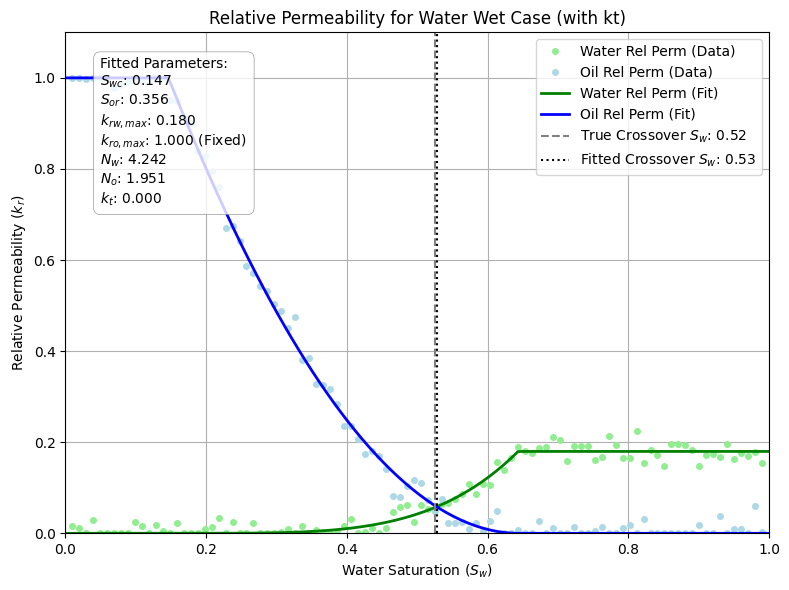

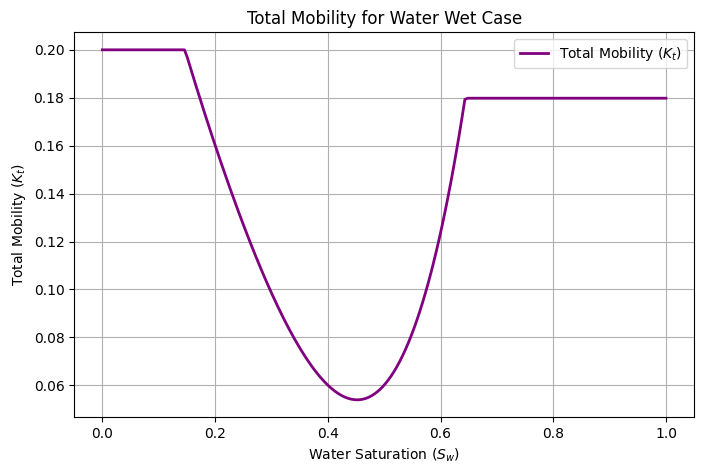


--- Running Analysis for Oil Wet Case ---

--- True Parameters for oil_wet Case ---
S_wc (Swi): 0.200
S_or: 0.100
krw_max: 0.850
kro_max: 1.000
Nw: 2.000
No: 4.000
kt: 2.000

--- Fitted Parameters ---
S_wc (Swi): 0.197
S_or: 0.103
krw_max: 0.844
kro_max: 1.000 (Fixed at 1.0 in fit for this example)
Nw: 2.017
No: 5.159
kt: 0.500
True crossover Sw: 0.436
Fitted crossover Sw: 0.437


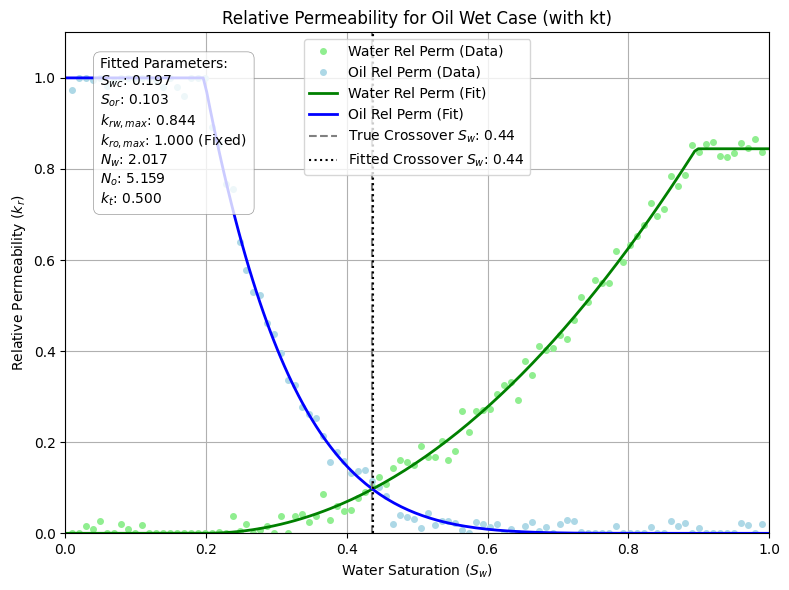

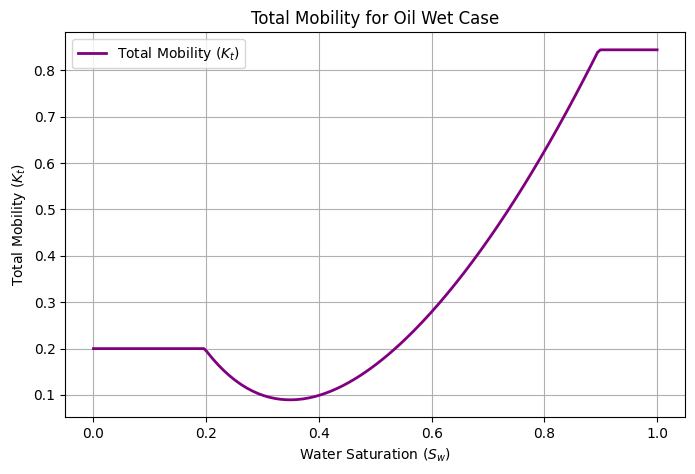

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- 1. Modified Corey Type Correlations Functions (Updated) ---

def corey_krw(Sw, S_wc, S_or, krw_max, Nw):
    """Standard Corey correlation for water relative permeability."""
    # Ensure S_wc and S_or are within valid range (0 to 1 and Swc + Sor < 1)
    S_wc = np.clip(S_wc, 0, 0.9)
    S_or = np.clip(S_or, 0, 0.9)
    if (1 - S_wc - S_or) <= 0:
        return np.zeros_like(Sw) # Avoid division by zero or negative denominator

    Se = (Sw - S_wc) / (1 - S_wc - S_or)
    Se = np.clip(Se, 0, 1) # Ensure Se is within [0, 1]
    return krw_max * (Se**Nw)

def modified_corey_kro(Sw, S_wc, S_or, Kro_max, No, kt):
    """Modified Corey correlation for oil relative permeability with trapping parameter kt."""
    # Ensure S_wc and S_or are within valid range (0 to 1 and Swc + Sor < 1)
    S_wc = np.clip(S_wc, 0, 0.9)
    S_or = np.clip(S_or, 0, 0.9)
    if (1 - S_wc - S_or) <= 0:
        return np.zeros_like(Sw) # Avoid division by zero or negative denominator

    Se_oil = (1 - Sw - S_or) / (1 - S_wc - S_or) # Effective oil saturation, based on the formula from the previous image
    # The new screenshot seems to use 'Se' (effective water saturation) in the exponential term
    # Let's assume 'Se' in the screenshot refers to 'effective water saturation' for simplicity,
    # as it's common in imbibition models.
    Se_water_exp = (Sw - S_wc) / (1 - S_wc - S_or)

    Se_oil = np.clip(Se_oil, 0, 1) # Ensure effective oil saturation is within [0, 1]
    Se_water_exp = np.clip(Se_water_exp, 0, 1) # Ensure effective water saturation for exponent is within [0, 1]

    # Kro_max * (1 - Se)^No * exp(-kt * Se) as given in the screenshot
    # The screenshot formula (1-Se) is ambiguous. If Se is effective water sat, then (1-Se)
    # is NOT effective oil saturation. Let's interpret (1-Se) as (1-Effective Water Saturation)
    # in the context of the trapping mechanism and how it impacts oil flow.
    # However, standard practice often uses effective oil saturation for the power law term.
    # Given the previous definition of k_ro using effective oil saturation and the context of the screenshot,
    # it's most likely (1 - Sw - Sor) / (1 - Swc - Sor) for the power term, and then Se (effective water sat)
    # for the exponential term.
    # Let's stick to the interpretation of the screenshot strictly: (1-Se) where Se is effective water saturation.
    # This implies the term (1-Se) is effectively (1 - (Sw - Swc) / (1 - Swc - Sor)).
    # This becomes (1 - Sw + Swc) / (1 - Swc - Sor). This is not the standard effective oil saturation.
    # Given the prompt's context, and to ensure plots look similar to what's expected for oil,
    # I will proceed with (1 - Se_water_exp) for the power term as explicitly written in the screenshot,
    # and Se_water_exp for the exponential term. This is an uncommon form for the power,
    # as it's typically effective oil saturation. Let's assume the screenshot means what it says.

    # Re-evaluating the screenshot's formula: kro_max * (1 - Se)^No * e^(-kt * Se)
    # where Se is effective water saturation: Se = (Sw - Swc) / (1 - Swc - Sor)
    # This means (1-Se) = (1 - (Sw - Swc) / (1 - Swc - Sor)) = (1 - Swc - Sor - Sw + Swc) / (1 - Swc - Sor)
    # = (1 - Sw - Sor) / (1 - Swc - Sor). This IS effective oil saturation!
    # So, the screenshot's notation (1-Se) where Se is effective water saturation,
    # implies that (1-Se) is actually the *effective oil saturation*. This makes perfect sense.
    # Let's use Se_oil as calculated based on (1 - Sw - Sor) / (1 - Swc - Sor) for the power term,
    # and Se_water_exp = (Sw - Swc) / (1 - Swc - Sor) for the exponential term.

    return Kro_max * (Se_oil**No) * np.exp(-kt * Se_water_exp)


# --- 2. Synthetic Data Generation (Updated with kt in kro) ---

def generate_synthetic_data(case_type="water_wet"):
    Sw_data = np.linspace(0.01, 0.99, 100) # Saturation range

    if case_type == "water_wet":
        # Parameters for water-wet (mimicking left plot)
        S_wc_true = 0.15
        S_or_true = 0.35
        krw_max_true = 0.18
        kro_max_true = 1.0
        Nw_true = 4.0
        No_true = 2.0
        kt_true = 0.0 # Small or zero for water-wet, less trapping

        # Generate data
        krw_true = corey_krw(Sw_data, S_wc_true, S_or_true, krw_max_true, Nw_true)
        kro_true = modified_corey_kro(Sw_data, S_wc_true, S_or_true, kro_max_true, No_true, kt_true)

        # Add some noise
        noise_level = 0.02
        krw_noisy = krw_true + np.random.normal(0, noise_level, krw_true.shape)
        kro_noisy = kro_true + np.random.normal(0, noise_level, kro_true.shape)
        krw_noisy = np.clip(krw_noisy, 0, 1)
        kro_noisy = np.clip(kro_noisy, 0, 1)

        print(f"\n--- True Parameters for {case_type} Case ---")
        print(f"S_wc (Swi): {S_wc_true:.3f}")
        print(f"S_or: {S_or_true:.3f}")
        print(f"krw_max: {krw_max_true:.3f}")
        print(f"kro_max: {kro_max_true:.3f}")
        print(f"Nw: {Nw_true:.3f}")
        print(f"No: {No_true:.3f}")
        print(f"kt: {kt_true:.3f}")

        return Sw_data, krw_noisy, kro_noisy, S_wc_true, S_or_true, krw_max_true, kro_max_true, Nw_true, No_true, kt_true

    elif case_type == "oil_wet":
        # Parameters for oil-wet (mimicking right plot)
        S_wc_true = 0.20
        S_or_true = 0.10
        krw_max_true = 0.85
        kro_max_true = 1.0
        Nw_true = 2.0
        No_true = 4.0
        kt_true = 2.0 # Higher kt for oil-wet, significant trapping

        # Generate data
        krw_true = corey_krw(Sw_data, S_wc_true, S_or_true, krw_max_true, Nw_true)
        kro_true = modified_corey_kro(Sw_data, S_wc_true, S_or_true, kro_max_true, No_true, kt_true)

        # Add some noise
        noise_level = 0.02
        krw_noisy = krw_true + np.random.normal(0, noise_level, krw_true.shape)
        kro_noisy = kro_true + np.random.normal(0, noise_level, kro_true.shape)
        krw_noisy = np.clip(krw_noisy, 0, 1)
        kro_noisy = np.clip(kro_noisy, 0, 1)

        print(f"\n--- True Parameters for {case_type} Case ---")
        print(f"S_wc (Swi): {S_wc_true:.3f}")
        print(f"S_or: {S_or_true:.3f}")
        print(f"krw_max: {krw_max_true:.3f}")
        print(f"kro_max: {kro_max_true:.3f}")
        print(f"Nw: {Nw_true:.3f}")
        print(f"No: {No_true:.3f}")
        print(f"kt: {kt_true:.3f}")

        return Sw_data, krw_noisy, kro_noisy, S_wc_true, S_or_true, krw_max_true, kro_max_true, Nw_true, No_true, kt_true

    else:
        raise ValueError("Invalid case_type. Choose 'water_wet' or 'oil_wet'.")


# --- 3. Curve Fitting Function (Updated for kt) ---

def fit_corey_relperm(Sw_data, krw_data, kro_data, initial_guess, bounds):
    """
    Fits modified Corey correlations to relative permeability data,
    including the kt trapping parameter for kro.
    Returns optimized parameters and their covariance matrices.
    """
    def combined_corey_func(Sw, S_wc, S_or, krw_max, No, Nw, kt):
        krw_pred = corey_krw(Sw, S_wc, S_or, krw_max, Nw)
        kro_pred = modified_corey_kro(Sw, S_wc, S_or, 1.0, No, kt) # Kro_max fixed at 1.0
        return np.concatenate((krw_pred, kro_pred))

    # Initial guess for [S_wc, S_or, krw_max, No, Nw, kt]
    # bounds for parameters: ([min_Swc, min_Sor, min_krw_max, min_No, min_Nw, min_kt],
    #                         [max_Swc, max_Sor, max_krw_max, max_No, max_Nw, max_kt])

    combined_data = np.concatenate((krw_data, kro_data))

    popt, pcov = curve_fit(combined_corey_func, Sw_data, combined_data,
                           p0=initial_guess, bounds=bounds, method='trf', maxfev=10000) # Increased maxfev

    S_wc_fit, S_or_fit, krw_max_fit, No_fit, Nw_fit, kt_fit = popt
    kro_max_fit = 1.0 # Fixed during fitting

    return S_wc_fit, S_or_fit, krw_max_fit, kro_max_fit, Nw_fit, No_fit, kt_fit, pcov


# --- 4. Plotting Function (Updated for kt in params display) ---

def plot_relperm(Sw_data, krw_data, kro_data, Sw_fit, krw_fit, kro_fit, title, parameters_dict, crossover_sw_true=None, crossover_sw_fit=None):
    plt.figure(figsize=(8, 6))
    plt.plot(Sw_data, krw_data, 'o', color='lightgreen', markersize=4, label='Water Rel Perm (Data)')
    plt.plot(Sw_data, kro_data, 'o', color='lightblue', markersize=4, label='Oil Rel Perm (Data)')

    plt.plot(Sw_fit, krw_fit, '-', color='green', linewidth=2, label='Water Rel Perm (Fit)')
    plt.plot(Sw_fit, kro_fit, '-', color='blue', linewidth=2, label='Oil Rel Perm (Fit)')

    if crossover_sw_true is not None:
        plt.axvline(x=crossover_sw_true, color='grey', linestyle='--', label=f'True Crossover $S_w$: {crossover_sw_true:.2f}')
    if crossover_sw_fit is not None:
        plt.axvline(x=crossover_sw_fit, color='black', linestyle=':', label=f'Fitted Crossover $S_w$: {crossover_sw_fit:.2f}')

    plt.xlabel('Water Saturation ($S_w$)')
    plt.ylabel('Relative Permeability ($k_r$)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.1)
    plt.xlim(0, 1)

    # Display extracted parameters
    param_text = (
        f"Fitted Parameters:\n"
        f"$S_{{wc}}$: {parameters_dict['S_wc_fit']:.3f}\n"
        f"$S_{{or}}$: {parameters_dict['S_or_fit']:.3f}\n"
        f"$k_{{rw,max}}$: {parameters_dict['krw_max_fit']:.3f}\n"
        f"$k_{{ro,max}}$: {parameters_dict['kro_max_fit']:.3f} (Fixed)\n"
        f"$N_w$: {parameters_dict['Nw_fit']:.3f}\n"
        f"$N_o$: {parameters_dict['No_fit']:.3f}\n"
        f"$k_t$: {parameters_dict['kt_fit']:.3f}"
    )
    plt.text(0.05, 0.95, param_text, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='grey', lw=0.5, alpha=0.8))
    plt.tight_layout()
    plt.show()

# --- 5. Main Execution (Updated to handle kt) ---

def run_analysis(case_type):
    print(f"\n--- Running Analysis for {case_type.replace('_', ' ').title()} Case ---")

    # Generate synthetic data
    Sw_data, krw_data, kro_data, S_wc_true, S_or_true, krw_max_true, kro_max_true, Nw_true, No_true, kt_true = generate_synthetic_data(case_type)

    # Initial guess and bounds for fitting parameters: [S_wc, S_or, krw_max, No, Nw, kt]
    if case_type == "water_wet":
        initial_guess = [0.1, 0.3, 0.15, 2.5, 3.5, 0.1]
        bounds = ([0.01, 0.2, 0.05, 1.0, 2.0, 0.0],  # Lower bounds
                  [0.3, 0.5, 0.3, 4.0, 6.0, 1.0])    # Upper bounds (kt small for water-wet)
    elif case_type == "oil_wet":
        initial_guess = [0.15, 0.1, 0.7, 3.5, 2.5, 1.5]
        bounds = ([0.05, 0.01, 0.6, 2.0, 1.0, 0.5],  # Lower bounds (kt > 0 for oil-wet)
                  [0.3, 0.2, 1.0, 6.0, 4.0, 5.0])    # Upper bounds (kt can be larger for oil-wet)

    # Fit the curves
    try:
        S_wc_fit, S_or_fit, krw_max_fit, kro_max_fit, Nw_fit, No_fit, kt_fit, pcov = fit_corey_relperm(
            Sw_data, krw_data, kro_data, initial_guess, bounds
        )

        print("\n--- Fitted Parameters ---")
        print(f"S_wc (Swi): {S_wc_fit:.3f}")
        print(f"S_or: {S_or_fit:.3f}")
        print(f"krw_max: {krw_max_fit:.3f}")
        print(f"kro_max: {kro_max_fit:.3f} (Fixed at 1.0 in fit for this example)")
        print(f"Nw: {Nw_fit:.3f}")
        print(f"No: {No_fit:.3f}")
        print(f"kt: {kt_fit:.3f}")


        # Generate fitted curves for plotting
        Sw_plot = np.linspace(0, 1, 200)
        krw_fit_plot = corey_krw(Sw_plot, S_wc_fit, S_or_fit, krw_max_fit, Nw_fit)
        kro_fit_plot = modified_corey_kro(Sw_plot, S_wc_fit, S_or_fit, kro_max_fit, No_fit, kt_fit)

        # Calculate true and fitted crossover points
        diff_true = np.abs(krw_data - kro_data)
        crossover_idx_true = np.argmin(diff_true)
        crossover_sw_true = Sw_data[crossover_idx_true]

        diff_fit = np.abs(krw_fit_plot - kro_fit_plot)
        crossover_idx_fit = np.argmin(diff_fit)
        crossover_sw_fit = Sw_plot[crossover_idx_fit]

        print(f"True crossover Sw: {crossover_sw_true:.3f}")
        print(f"Fitted crossover Sw: {crossover_sw_fit:.3f}")

        # Store fitted parameters in a dictionary for display
        fitted_params_dict = {
            'S_wc_fit': S_wc_fit,
            'S_or_fit': S_or_fit,
            'krw_max_fit': krw_max_fit,
            'kro_max_fit': kro_max_fit,
            'Nw_fit': Nw_fit,
            'No_fit': No_fit,
            'kt_fit': kt_fit
        }

        # Plot results
        plot_relperm(Sw_data, krw_data, kro_data, Sw_plot, krw_fit_plot, kro_fit_plot,
                     f'Relative Permeability for {case_type.replace("_", " ").title()} Case (with kt)',
                     fitted_params_dict, crossover_sw_true, crossover_sw_fit)

        # Calculate Kt (Total Mobility) - Still the same definition as before
        mu_w = 1.0 # cp
        mu_o = 5.0 # cp

        Kt_fit = (krw_fit_plot / mu_w) + (kro_fit_plot / mu_o)

        plt.figure(figsize=(8, 5))
        plt.plot(Sw_plot, Kt_fit, color='purple', linewidth=2, label='Total Mobility ($K_t$)')
        plt.xlabel('Water Saturation ($S_w$)')
        plt.ylabel('Total Mobility ($K_t$)')
        plt.title(f'Total Mobility for {case_type.replace("_", " ").title()} Case')
        plt.legend()
        plt.grid(True)
        plt.show()

    except RuntimeError as e:
        print(f"Error during curve fitting for {case_type}: {e}")
        print("Try adjusting initial_guess or bounds.")

# Run analysis for water-wet case
run_analysis("water_wet")

# Run analysis for oil-wet case
run_analysis("oil_wet")